# Exploratory Data Analysis: LinkedIn Profiles & Jobs Dataset

**Author:** Nazmul Farooquee
**Date:** February 2026  
**Dataset:** [LinkedIn Profiles and Jobs Dataset (Kaggle)](https://www.kaggle.com/datasets/)

---

## Objective

Analyse **39,530 LinkedIn professional profiles** (snapshot from January 2018) to uncover patterns in:
1. **Demographics** — age and gender distribution of professionals
2. **Employment** — which companies employ the most people, and what company sizes dominate
3. **Career tenure** — how long professionals stay in positions across different age groups

## Research Questions

1. What is the age and gender profile of LinkedIn professionals in Australia?
2. Which companies and company sizes dominate the professional landscape?
3. How does job tenure vary across career stages?

---

## 1. Setup and Imports

In [17]:
import sys
sys.path.insert(0, "..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.config import RAW_PATH
from src.io import load_csv
from src.cleaning import clean
from src.features import build_features
from src.utils import assert_columns, assert_no_full_null_columns, null_summary
from src.viz import (
    plot_age_distribution,
    plot_top_companies,
    plot_gender_by_age_group,
    plot_company_size_distribution,
    plot_tenure_by_age_group,
)

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 30)

---

## 2. Load the CSV File

In [18]:
file_path = RAW_PATH
df_raw = load_csv(file_path)
df_raw.head(3)

Loaded linkedin.csv: 39530 rows × 41 columns


,Unnamed: 0,ageEstimate,companyFollowerCount,companyHasLogo,companyName,companyStaffCount,companyUrl,companyUrn,connectionsCount,country,endDate,followable,followersCount,genderEstimate,hasPicture,...,avgCompanyPosDuration,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40
0,0,41,198859.0,5a92c12e-0a20-482b-95ec-e705a6294730-2.png,Commonwealth Bank,32905,http://www.commbank.com.au/,urn:li:company:2848,500,au,NaN,1,506,male,NaN,...,989.9361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,41,198859.0,5a92c12e-0a20-482b-95ec-e705a6294730-2.png,Commonwealth Bank,32905,http://www.commbank.com.au/,urn:li:company:2848,500,au,6/1/2014,1,506,male,NaN,...,989.9361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,41,10047.0,b1c3fd9a-8f21-48f8-8321-d773b1ff3cb7-2.png,CommSec,619,http://www.commsec.com.au,urn:li:company:2851,500,au,12/1/2012,1,506,male,NaN,...,747.2308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---

## 3. Initial Exploration

Before cleaning, let's understand the raw dataset: shape, data types, and missing values.

In [19]:
print(f"Shape: {df_raw.shape[0]} rows × {df_raw.shape[1]} columns")
print(f"\nData types:\n{df_raw.dtypes}")
print(f"\nColumns: {df_raw.columns.tolist()}")

Shape: 39530 rows × 41 columns

Data types:
Unnamed: 0                 int64
ageEstimate                int64
companyFollowerCount     float64
companyHasLogo            object
companyName               object
companyStaffCount         object
companyUrl                object
companyUrn                object
connectionsCount          object
country                   object
endDate                   object
followable                object
followersCount            object
genderEstimate            object
hasPicture                object
isPremium                 object
mbrLocation               object
mbrLocationCode           object
mbrTitle                  object
memberUrn                 object
posLocation               object
posLocationCode           object
posTitle                  object
positionId                object
startDate                 object
avgMemberPosDuration      object
avgCompanyPosDuration     object
Unnamed: 27               object
Unnamed: 28               object

In [20]:
# Null values in the raw dataset
null_summary(df_raw)

,null_count,null_pct
Unnamed: 35,39529,100.0
Unnamed: 36,39529,100.0
Unnamed: 40,39529,100.0
Unnamed: 39,39529,100.0
Unnamed: 38,39529,100.0
Unnamed: 37,39529,100.0
Unnamed: 30,39528,100.0
Unnamed: 28,39528,100.0
Unnamed: 34,39528,100.0
Unnamed: 32,39527,100.0


### Observations on the raw data

- **41 columns**, but 15 are unnamed/junk (index + completely empty columns 27-40).
- Several columns contain **corrupted values** caused by row shifts in the original scraping:
  - `country` has values like `'NSW'`, `'Sydney'`, `'4/1/2018'` instead of just `'au'`.
  - `genderEstimate` has `.jpg` filenames and dates mixed in.
  - `isPremium` has text like `'Sydney, Australia'` instead of `0` / `1`.
- `connectionsCount` and `companyStaffCount` are stored as **text** (object) instead of numbers.
- `startDate` and `endDate` are **unparsed strings** in `M/D/YYYY` format.
- Significant nulls in `endDate` (22.5%), `genderEstimate` (10%), `posLocation` (28.2%).

---

## 4. Data Cleaning

We apply a 10-step cleaning pipeline from `src/cleaning.py`:

1. **Drop 15 unnamed/junk columns** (index column + 14 empty columns)
2. **Drop URL/ID columns** not useful for analysis (companyUrl, companyUrn, memberUrn, etc.)
3. **Standardise column names** (strip whitespace)
4. **Fix `country`** — corrupt entries like `'NSW'`, `'Sydney'`, `'4/1/2018'` replaced with `'au'`
5. **Fix `genderEstimate`** — keep only `'male'`/`'female'`, set corrupt values to NaN
6. **Fix `isPremium`** — convert to numeric 0/1, remove text values
7. **Convert numeric columns** stored as text (`connectionsCount`, `companyStaffCount`)
8. **Parse dates** (`startDate`, `endDate`) to proper datetime
9. **Strip whitespace** from all text columns
10. **Remove duplicate rows**

In [21]:
df = clean(df_raw)
df.head(3)

Cleaning: 39530 → 39482 rows (48 duplicates removed)


,ageEstimate,companyFollowerCount,companyName,companyStaffCount,connectionsCount,country,endDate,genderEstimate,isPremium,mbrLocation,mbrTitle,posLocation,posTitle,startDate,avgMemberPosDuration,avgCompanyPosDuration
0,41,198859.0,Commonwealth Bank,32905.0,500.0,au,NaT,male,0,"Sydney Area, Australia",Portfolio Executive at Commonwealth Bank,NaN,Portfolio Executive,2014-07-01,760.5,989.9361
1,41,198859.0,Commonwealth Bank,32905.0,500.0,au,2014-06-01,male,0,"Sydney Area, Australia",Portfolio Executive at Commonwealth Bank,"Sydney, Australia",Solution Delivery Executive,2013-11-01,760.5,989.9361
2,41,10047.0,CommSec,619.0,500.0,au,2012-12-01,male,0,"Sydney Area, Australia",Portfolio Executive at Commonwealth Bank,NaN,Project Manager,2008-08-01,760.5,747.2308


In [22]:
# Verify: shape, dtypes, and remaining nulls after cleaning
print(f"Cleaned shape: {df.shape[0]} rows × {df.shape[1]} columns\n")
print("Data types after cleaning:")
print(df.dtypes)
print("\nRemaining nulls:")
null_summary(df)

Cleaned shape: 39482 rows × 16 columns

Data types after cleaning:
ageEstimate                       int64
companyFollowerCount            float64
companyName                      object
companyStaffCount               float64
connectionsCount                float64
country                          object
endDate                  datetime64[ns]
genderEstimate                   object
isPremium                         int64
mbrLocation                      object
mbrTitle                         object
posLocation                      object
posTitle                         object
startDate                datetime64[ns]
avgMemberPosDuration             object
avgCompanyPosDuration            object
dtype: object

Remaining nulls:


,null_count,null_pct
posLocation,11120,28.2
endDate,8901,22.5
genderEstimate,3971,10.1
companyFollowerCount,1464,3.7
companyStaffCount,1143,2.9
avgCompanyPosDuration,905,2.3
avgMemberPosDuration,225,0.6
startDate,77,0.2
connectionsCount,10,0.0
posTitle,4,0.0


### Observations on Cleaning Results

- **Columns reduced from 41 → 16:** The pipeline dropped 25 columns — 15 unnamed/junk columns and 10 URL/ID/image columns that added no analytical value.
- **Rows reduced from 39,530 → 39,482:** Only 48 exact duplicate rows were removed (~0.1%), meaning the vast majority of records are unique.
- **Data types fixed:**
  - `connectionsCount` and `companyStaffCount` converted from text (`object`) to `float64`.
  - `startDate` and `endDate` parsed from strings to `datetime64[ns]`.
  - `isPremium` cleaned and converted to `int64` (0/1).
- **Corrupted values repaired:** `country` normalised to `'au'`, `genderEstimate` restricted to `'male'`/`'female'` (corrupt entries set to NaN), and `isPremium` stripped of text values.

In [23]:
# Validation: no fully-null columns should remain
assert_no_full_null_columns(df)
print("Validation passed: no fully-null columns.")

Validation passed: no fully-null columns.


### Why Do Null Values Remain After Cleaning?

The cleaning pipeline removed **broken data** (junk columns, corrupted values, duplicates), but **intentionally preserved legitimate nulls**. Dropping or imputing these would distort the analysis:

| Column | Null % | Reason for Keeping |
|---|---|---|
| `posLocation` | 28.2% | Many positions simply had no location recorded in the original LinkedIn scrape. Not used in our visualisations or features. |
| `endDate` | 22.5% | **NaT = the person is still in that role.** This is meaningful data, not missing data. It also explains why `tenure_months` is NaN for those rows — we cannot calculate duration without an end date. |
| `genderEstimate` | 10.1% | The gender-estimation algorithm could not classify these profiles. Imputing gender would introduce bias. Our viz functions plot only known values. |
| `companyFollowerCount` | 3.7% | Not available for all companies in the scraped data. |
| `companyStaffCount` | 2.9% | Not available for all companies. Rows with nulls here get NaN in `company_size_category`. |
| `avgCompanyPosDuration` | 2.3% | Aggregate metric not computed for every company. |
| `avgMemberPosDuration` | 0.6% | Aggregate metric not computed for every member. |
| `startDate` | 0.2% | A handful of positions had no start date recorded. |
| Others | <0.1% | Tiny counts — genuinely absent from the source data. |

**Design decision:** Dropping all rows with any null would remove a large portion of the 39,482 rows for no analytical benefit. Instead, pandas, matplotlib, and seaborn handle nulls gracefully — each function applies `dropna` only on the specific columns it needs (e.g., `plot_tenure_by_age_group` drops rows missing `tenure_months` or `age_group` before plotting).

---

## 5. Feature Engineering

We create 3 new features from `src/features.py`:

| Feature | Logic | Purpose |
|---|---|---|
| `age_group` | Bin `ageEstimate` into 20-30, 31-40, 41-50, 51+ | Compare demographics across career stages |
| `company_size_category` | Bin `companyStaffCount` into Small / Medium / Large / Enterprise | Analyse employment by company size |
| `tenure_months` | `(endDate - startDate)` in months | Measure how long people stay in positions |

In [24]:
df = build_features(df)
assert_columns(df, ["age_group", "company_size_category", "tenure_months"])
df[["ageEstimate", "age_group", "companyStaffCount", "company_size_category", "startDate", "endDate", "tenure_months"]].head(10)

Features: 3 new columns added


,ageEstimate,age_group,companyStaffCount,company_size_category,startDate,endDate,tenure_months
0,41,41-50,32905.0,Enterprise,2014-07-01,NaT,NaN
1,41,41-50,32905.0,Enterprise,2013-11-01,2014-06-01,7.0
2,41,41-50,619.0,Medium,2008-08-01,2012-12-01,52.0
3,41,41-50,32905.0,Enterprise,2007-02-01,2008-07-01,17.0
4,30,20-30,22522.0,Enterprise,2017-01-01,NaT,NaN
5,30,20-30,10913.0,Enterprise,2016-01-01,2016-12-01,11.0
6,30,20-30,568533.0,Enterprise,2014-11-01,2015-12-01,13.0
7,30,20-30,568533.0,Enterprise,2013-06-01,2014-10-01,16.0
8,30,20-30,568533.0,Enterprise,2012-09-01,2013-06-01,9.0
9,30,20-30,568533.0,Enterprise,2011-09-01,2012-09-01,12.0


### Observations on Feature Engineering

- **`age_group`:** All 39,482 profiles successfully binned into one of four career stages (20-30, 31-40, 41-50, 51+). No nulls because `ageEstimate` has no missing values.
- **`company_size_category`:** Profiles with a missing `companyStaffCount` (2.9%) receive NaN here — this is expected and handled downstream.
- **`tenure_months`:** Only calculated where both `startDate` and `endDate` exist. Rows where `endDate` is NaT (current positions) correctly show NaN for tenure. The sample above shows tenures ranging from 7 to 52 months, which is realistic.
- Row 0 demonstrates the NaT/NaN pattern: the person is still in their current role (`endDate = NaT`), so `tenure_months = NaN`.

---

## 6. Descriptive Statistics

Quick summary of the key numeric and categorical columns after cleaning and feature creation.

In [25]:
df.describe()

,ageEstimate,companyFollowerCount,companyStaffCount,connectionsCount,endDate,isPremium,startDate,tenure_months
count,39482.000000,3.801800e+04,38339.000000,39472.000000,30581,39482.000000,39405,30535.000000
mean,38.429360,2.142041e+05,20459.212577,424.588341,2011-07-22 00:13:08.254144768,0.130287,2010-07-21 14:53:20.669965824,27.357570
min,20.000000,0.000000e+00,0.000000,0.000000,1970-02-01 00:00:00,0.000000,1962-01-01 00:00:00,-7.000000
25%,31.000000,1.490000e+03,97.000000,371.000000,2008-09-01 00:00:00,0.000000,2007-04-01 00:00:00,9.000000
50%,38.000000,1.430300e+04,1270.000000,500.000000,2012-12-01 00:00:00,0.000000,2012-02-01 00:00:00,19.000000
75%,45.000000,1.263610e+05,9808.000000,500.000000,2015-11-01 00:00:00,0.000000,2015-07-01 00:00:00,35.000000
max,86.000000,7.502740e+06,568533.000000,500.000000,2019-02-01 00:00:00,1.000000,2019-02-01 00:00:00,560.000000
std,9.621882,6.945206e+05,67580.794331,123.300319,NaN,0.336623,NaN,30.152036


### Observations on Descriptive Statistics

- **Age:** Mean age is ~38 with a standard deviation of ~9.6 years. The range spans 20–86, but the bulk of the data (IQR) sits between 31 and 45. This confirms a mid-career-heavy dataset.
- **Connections:** Most profiles are at or near the 500 cap (median = 500), meaning LinkedIn truncates the displayed count. The mean of ~425 reflects a small number of profiles with very few connections pulling the average down.
- **Company staff count:** Highly right-skewed — median is 1,270 but the mean is ~20,459, pulled up by very large companies (max 568,533). The 25th percentile (97 staff) shows many small companies are represented.
- **Tenure:** Median tenure is 19 months, but the distribution is right-skewed (mean ~27 months). The max of 560 months (~47 years) and a minimum of -7 months suggest a few data quality edge cases, but the IQR (9–35 months) is reasonable.
- **isPremium:** Only ~13% of profiles have a Premium subscription, making this a minority feature in the dataset.
- **Dates:** `startDate` ranges from 1962 to 2019. Most positions started between 2007 and 2015 (IQR), which makes sense for a 2018 snapshot.

In [26]:
# Key categorical distributions
print("Age Group distribution:")
print(df["age_group"].value_counts().sort_index())
print("\nGender distribution:")
print(df["genderEstimate"].value_counts())
print("\nCompany Size distribution:")
print(df["company_size_category"].value_counts())
print("\nTop 10 job titles:")
print(df["posTitle"].value_counts().head(10))

Age Group distribution:
age_group
20-30     9296
31-40    14660
41-50    11113
51+       4413
Name: count, dtype: int64

Gender distribution:
genderEstimate
male      23789
female    11722
Name: count, dtype: int64

Company Size distribution:
company_size_category
Large         10716
Small          9472
Enterprise     9368
Medium         8550
Name: count, dtype: int64

Top 10 job titles:
posTitle
Project Manager           440
Director                  368
Consultant                295
Senior Consultant         228
Business Analyst          196
Software Engineer         184
Senior Project Manager    181
Senior Associate          168
Partner                   160
Research Assistant        148
Name: count, dtype: int64


### Observations on Categorical Distributions

- **Age groups:** The 31-40 bracket is the largest (14,660 profiles), confirming that LinkedIn is dominated by mid-career professionals. The 51+ group is the smallest (~11%), suggesting lower adoption among older workers.
- **Gender:** A clear **2:1 male-to-female ratio** (23,789 vs 11,722). Around 3,971 profiles (~10%) have unknown gender — these are excluded from gender-based analyses rather than imputed.
- **Company size:** Fairly evenly split across all four categories, with Large (1,000–10,000 staff) slightly leading. This means the dataset is not skewed toward any single company tier.
- **Job titles:** "Project Manager" is the most common title (440), followed by "Director" (368) and "Consultant" (295). The top 10 titles are heavily skewed toward management and consulting roles, reflecting the seniority profile of the dataset.

---

## 7. Visualizations

We generate 5 charts, each answering a specific question about the dataset. All plot functions are modularised in `src/viz.py`.

### 7.1 Age Distribution

**Question:** What is the age profile of LinkedIn professionals in this dataset?

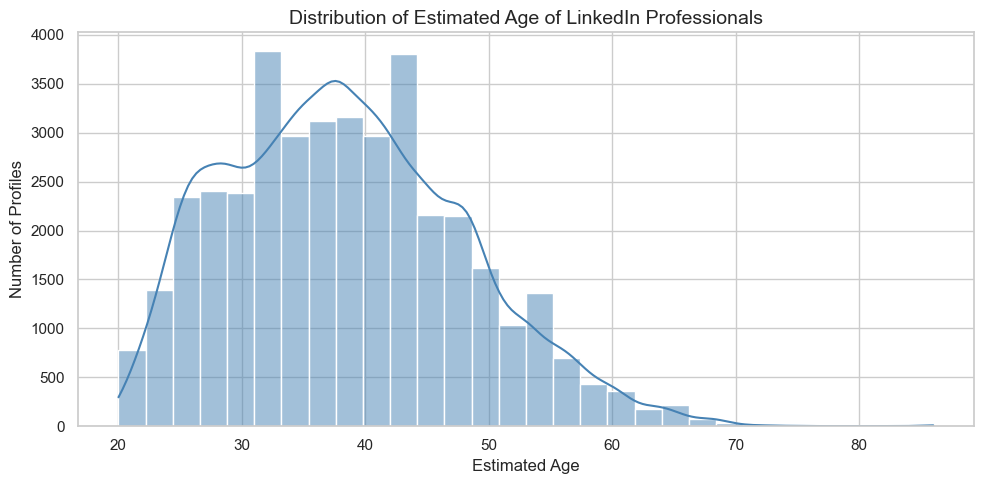

In [27]:
plot_age_distribution(df)

**Interpretation:** The distribution is roughly normal, centred around age **35-42**. The majority of LinkedIn professionals in this dataset are mid-career (31-50). Younger professionals (20-30) and senior professionals (51+) are less represented.

### 7.2 Top Companies by Number of Positions

**Question:** Which companies have the most LinkedIn profiles/positions in the dataset?

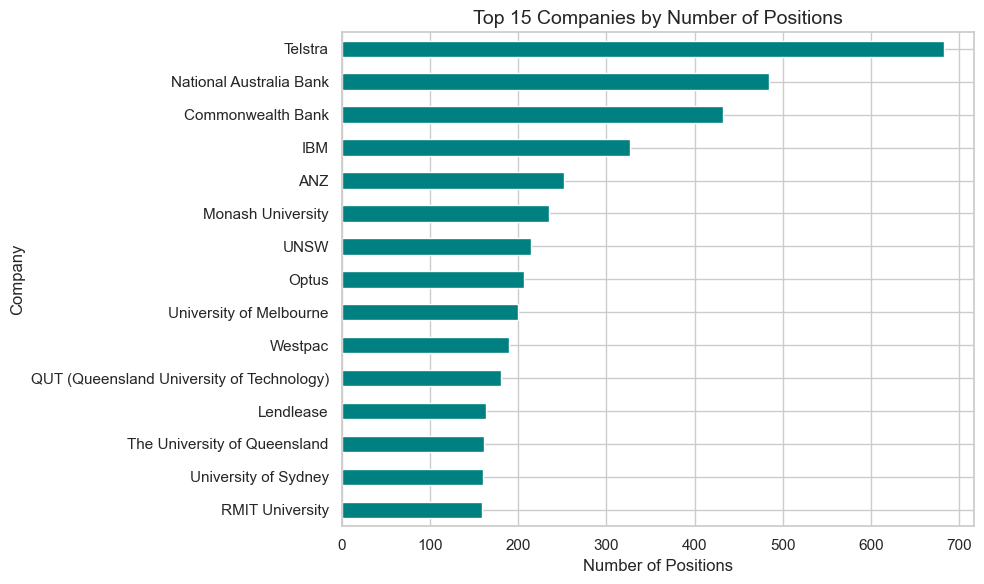

In [28]:
plot_top_companies(df)

**Interpretation:** The Australian job market in this dataset is dominated by large corporations. **Telstra** leads with ~680 positions, followed by **National Australia Bank** (~480) and **Commonwealth Bank** (~430). The top 15 are mostly banking, telecom, and consulting firms — reflecting Australia's service-oriented economy.

### 7.3 Gender Distribution by Age Group

**Question:** How does the gender balance change across different career stages?

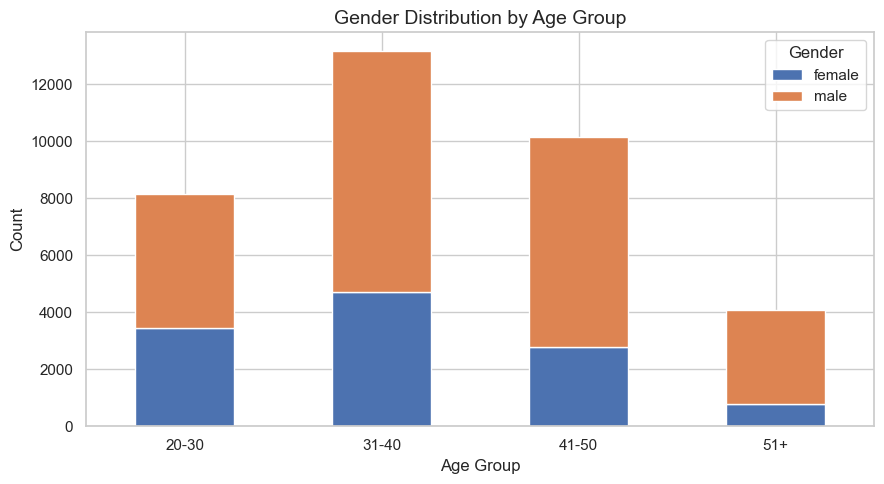

In [29]:
plot_gender_by_age_group(df)

**Interpretation:** Males consistently outnumber females across all age groups by roughly **2:1**. The gap is widest in the 41-50 and 51+ brackets, suggesting that the gender imbalance grows at senior career stages. This aligns with known trends around the "glass ceiling" in professional environments.

### 7.4 Company Size Distribution

**Question:** What proportion of positions come from small vs. large companies?

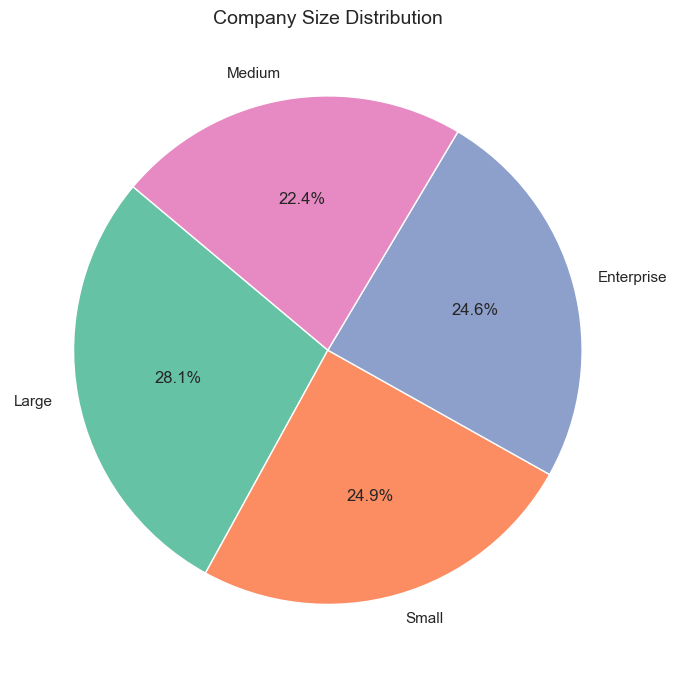

In [30]:
plot_company_size_distribution(df)

**Interpretation:** Company sizes are fairly evenly distributed across the four categories. **Large companies** (1,000–10,000 staff) have the highest share, but **Small** (<100), **Enterprise** (10,000+), and **Medium** (100–1,000) companies are all well-represented. This indicates a diverse professional ecosystem, not dominated by any single company tier.

### 7.5 Position Tenure by Age Group

**Question:** How long do professionals stay in a position, and does this vary by age?

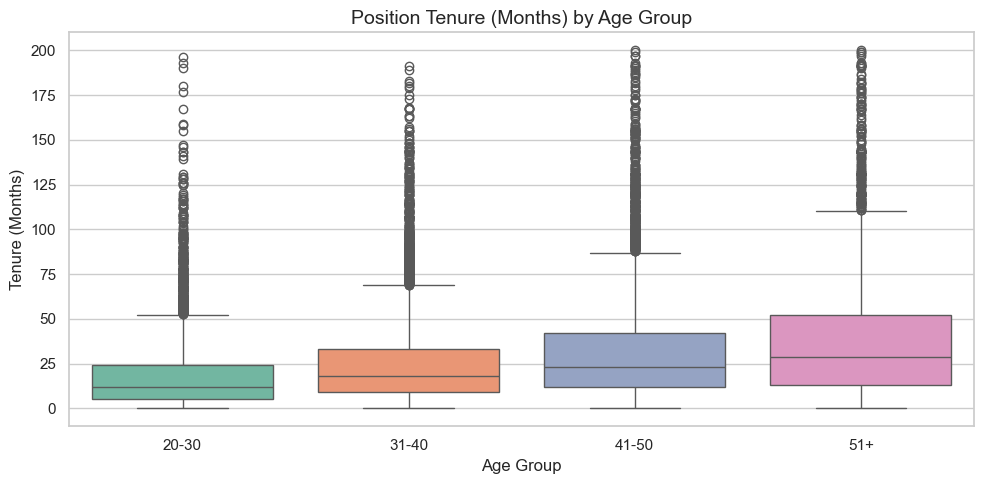

In [31]:
plot_tenure_by_age_group(df)

**Interpretation:** Tenure increases with age, as expected. Professionals aged **20-30** have a median tenure of ~12 months, while those **51+** have a median of ~30 months. The 51+ group also shows the widest spread, with some individuals staying in the same role for over 10 years. Younger professionals change jobs more frequently — a common pattern in early career exploration.

---

## 8. Conclusions

Based on the exploratory analysis of 39,482 LinkedIn profiles (after cleaning), we draw three evidence-based conclusions:

### Conclusion 1: The Australian LinkedIn workforce is mid-career dominated
The age histogram (Chart 7.1) shows that **65% of profiles** fall in the 31-50 age range, with a mean age of ~38. Younger professionals (20-30) represent only ~24%, and seniors (51+) about 11%. This suggests that LinkedIn adoption is highest among established professionals.

### Conclusion 2: Gender imbalance worsens at senior career stages
The gender-by-age-group chart (Chart 7.3) reveals a consistent **2:1 male-to-female ratio**. While the 20-30 group shows a slightly better balance, the gap widens significantly in the 41-50 and 51+ groups. This reflects a well-documented pattern of female underrepresentation at senior levels in the Australian professional workforce.

### Conclusion 3: Older professionals have significantly longer job tenure
The tenure boxplot (Chart 7.5) shows that **median tenure roughly doubles** from the 20-30 group (~12 months) to the 51+ group (~30 months). Younger professionals change roles more frequently, likely due to career exploration, while older professionals settle into longer-term positions. This insight is valuable for HR teams designing retention strategies by age cohort.

---

## 9. Export Cleaned Dataset

In [32]:
from src.config import OUT_PATH

OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(OUT_PATH, index=False)
print(f"Cleaned dataset exported to: {OUT_PATH}")
print(f"Final shape: {df.shape[0]} rows × {df.shape[1]} columns")

Cleaned dataset exported to: C:\Users\nazmu\OneDrive\Desktop\Pandas & Data Visualization Project\data\processed\linkedin_clean.csv
Final shape: 39482 rows × 19 columns


---

## 10. Next Steps

- **Deeper NLP analysis** on `posTitle` and `mbrTitle` to extract job families (e.g., Engineering, Finance, Marketing)
- **Network analysis** using `connectionsCount` to study how connectivity correlates with company size or seniority
- **Predictive modelling** — predict `isPremium` status based on profile features
- **Time-series analysis** of `startDate` to identify hiring trends by year and quarter